In [96]:
import feedparser
import requests
import re
import pandas as pd
import time
import smtplib
from email.mime.text import MIMEText
from typing import List, Dict, Any
import os
import json
import numpy as np

# --- CONFIGURATION ---
ANSSI_FEEDS = [
    ("Avis", "https://www.cert.ssi.gouv.fr/avis/feed/"),
    ("Alerte", "https://www.cert.ssi.gouv.fr/alerte/feed/")
]
RATE_LIMIT_SECONDS = 2
CSV_OUTPUT = "consolidated_anssi_cve.csv"

In [97]:
# --- STEP 1: Extract ANSSI RSS Feeds ---
def extract_anssi_feeds() -> List[Dict[str, Any]]:
    bulletins = []
    for bulletin_type, url in ANSSI_FEEDS:
        print(f"Extraction du flux RSS pour {bulletin_type} depuis {url}...")
        feed = feedparser.parse(url)
        for entry in feed.entries:
            # Robust extraction of ANSSI ID from link or id
            link = str(getattr(entry, 'link', ''))
            id_anssi = ''
            if link:
                parts = link.rstrip('/').split('/')
                if len(parts) > 1:
                    id_anssi = parts[-1] if parts[-1] else parts[-2]
            if not id_anssi and hasattr(entry, 'id'):
                id_anssi = str(entry.id)
            bulletins.append({
                "id_anssi": id_anssi,
                "titre_anssi": entry.title,
                "type": bulletin_type,
                "date": entry.published,
                "link": link
            })
    print(f"Nombre total de bulletins extraits : {len(bulletins)}")
    return bulletins

In [98]:
# --- STEP 2: Extract CVEs from ANSSI bulletin web page ---
def extract_cves_from_bulletin(bulletin: Dict[str, Any]) -> List[Dict[str, Any]]:
    print(f"Extraction des CVE depuis le bulletin : {bulletin['id_anssi']} ({bulletin['titre_anssi']})")
    cve_list = []
    try:
        # Download the bulletin web page
        response = requests.get(bulletin["link"], timeout=10)
        html = response.text
        # Extract CVE identifiers using regex
        cve_pattern = r"CVE-\d{4}-\d{4,7}"  # FIXED: single backslash for regex
        cve_list = list(set(re.findall(cve_pattern, html)))
        print(f"Nombre de CVE trouvés : {len(cve_list)}")
        return [{"cve": cve, "html": html} for cve in cve_list]
    except Exception as e:
        print(f"Erreur lors de l'extraction des CVE depuis la page web: {e}")
        return []

In [99]:
# --- STEP 3: Enrich CVE with MITRE and EPSS APIs ---
def enrich_cve(cve_id: str) -> Dict[str, Any]:
    print(f"Enrichissement des données pour la CVE : {cve_id}")
    # MITRE CVE API
    mitre_url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
    cve_info = {
        "cvss": None, "base_severity": None, "cwe": None, "cwe_desc": None,
        "description": None, "vendor": None, "product": None, "versions": ""
    }
    try:
        r = requests.get(mitre_url, timeout=10)
        data = r.json()
        cna = data["containers"]["cna"]
        cve_info["description"] = cna["descriptions"][0]["value"] if cna.get("descriptions") else None
        # CVSS
        metrics = cna.get("metrics", [])
        if metrics:
            for metric in metrics:
                for key in metric:
                    if key.startswith("cvssV3"):
                        cve_info["cvss"] = metric[key].get("baseScore")
                        cve_info["base_severity"] = metric[key].get("baseSeverity")
        # CWE
        problemtype = cna.get("problemTypes", [])
        if problemtype and "descriptions" in problemtype[0]:
            cve_info["cwe"] = problemtype[0]["descriptions"][0].get("cweId", "Non disponible")
            cve_info["cwe_desc"] = problemtype[0]["descriptions"][0].get("description", "Non disponible")
        # Vendor/Product/Versions
        affected = cna.get("affected", [])
        if affected:
            cve_info["vendor"] = affected[0].get("vendor")
            cve_info["product"] = affected[0].get("product")
            versions = [v["version"] for v in affected[0].get("versions", []) if v.get("status") == "affected"]
            cve_info["versions"] = ", ".join(versions) if versions else ""
    except Exception as e:
        print(f"Erreur enrichissement MITRE pour {cve_id}: {e}")
    # EPSS API
    epss_url = f"https://api.first.org/data/v1/epss?cve={cve_id}"
    try:
        r = requests.get(epss_url, timeout=10)
        data = r.json()
        epss_data = data.get("data", [])
        cve_info["epss"] = epss_data[0]["epss"] if epss_data else None
    except Exception as e:
        print(f"Erreur enrichissement EPSS pour {cve_id}: {e}")
        cve_info["epss"] = None
    print(f"Enrichissement terminé pour {cve_id}")
    return cve_info

In [100]:
# --- STEP 4: Consolidate Data ---
def consolidate_data():
    print("Consolidation des données dans le DataFrame...")
    bulletins = extract_anssi_feeds()
    all_rows = []
    for i, bulletin in enumerate(bulletins, 1):
        print(f"Traitement du bulletin {i}/{len(bulletins)} : {bulletin['id_anssi']}")
        cves = extract_cves_from_bulletin(bulletin)
        for j, cve_entry in enumerate(cves, 1):
            print(f"  Traitement de la CVE {j}/{len(cves)} pour ce bulletin...")
            cve_id = cve_entry["cve"]
            cve_info = enrich_cve(cve_id)
            row = {
                "ID ANSSI": bulletin["id_anssi"],
                "Titre ANSSI": bulletin["titre_anssi"],
                "Type": bulletin["type"],
                "Date": bulletin["date"],
                "CVE": cve_id,
                "CVSS": cve_info["cvss"],
                "Base Severity": cve_info["base_severity"],
                "CWE": cve_info["cwe"],
                "CWE Description": cve_info["cwe_desc"],
                "EPSS": cve_info["epss"],
                "Lien": bulletin["link"],
                "Description": cve_info["description"],
                "Éditeur": cve_info["vendor"],
                "Produit": cve_info["product"],
                "Versions affectées": cve_info["versions"]
            }
            all_rows.append(row)
            time.sleep(RATE_LIMIT_SECONDS)
    print(f"Nombre total de lignes consolidées : {len(all_rows)}")
    df = pd.DataFrame(all_rows)
    df.to_csv(CSV_OUTPUT, index=False)
    print(f"CSV consolidé écrit dans {CSV_OUTPUT}")
    return df

In [101]:
# --- UTILITY FUNCTIONS ---
def get_file_list(path: str) -> list:
    """Returns a list of files in a directory."""
    try:
        return os.listdir(path)
    except Exception as e:
        print(f"Error reading directory {path}: {e}")
        return []

def parse_json_file(filepath: str) -> dict:
    """Loads and returns JSON data from a file."""
    try:
        with open(filepath, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error reading file {filepath}: {e}")
        return {}

def extract_cve_info(data: dict, entry_id: str, entry_type: str, first_list: list, mitre_list: list, path: str) -> list:
    """Extracts CVE info from a single alert/avis JSON."""
    cve_list = []
    for cve in data.get("cves", []):
        cve_id = cve['name']
        dico = {
            'id': entry_id,
            'title': '',
            'type': entry_type,
            'publication_date': None,
            'cve_id': cve_id,
            'original_link': None,
            'epss': np.nan,
            'description': None,
            'cwe': 'Non disponible',
            'cwe_desc': 'Non disponible',
            'vendor': [],
            'product': [],
            'affected_versions': [],
            'cvss': np.nan,
            'severity': None
        }
        # Info from vendor_advisories (safe access)
        vendor_advisories = data.get('vendor_advisories', [])
        if vendor_advisories and isinstance(vendor_advisories, list):
            vendor_adv = vendor_advisories[0]
            dico['title'] = vendor_adv.get('title', '')
            dico['publication_date'] = vendor_adv.get('published_at')
            dico['original_link'] = vendor_adv.get('url')
        # Info from first
        if cve_id in first_list:
            data_first = parse_json_file(os.path.join(path, "first", cve_id))
            if data_first.get('data') and 'epss' in data_first['data'][0]:
                dico['epss'] = data_first['data'][0]['epss']
        # Info from mitre
        if cve_id in mitre_list:
            data_mitre = parse_json_file(os.path.join(path, "mitre", cve_id))
            cna = data_mitre.get('containers', {}).get('cna', {})
            if 'descriptions' in cna:
                dico['description'] = cna['descriptions'][0].get('value')
            # CWE
            problemtype = cna.get('problemTypes', [{}])
            if problemtype and 'descriptions' in problemtype[0]:
                dico['cwe'] = problemtype[0]['descriptions'][0].get('cweId', 'Non disponible')
                dico['cwe_desc'] = problemtype[0]['descriptions'][0].get('description', 'Non disponible')
            # Affected products
            for product in cna.get('affected', []):
                if 'vendor' in product:
                    dico['vendor'].append(product['vendor'])
                if 'product' in product:
                    dico['product'].append(product['product'])
                if 'versions' in product:
                    dico['affected_versions'] = [v["version"] for v in product["versions"] if v["status"] == "affected"]
            # CVSS and severity
            keys = ['cvssV3_0', 'cvssV3_1', 'cvssV2', 'cvssV4_0']
            metrics = cna.get('metrics', [{}])
            if metrics:
                cvss_info = metrics[0]
                for key in keys:
                    if key in cvss_info:
                        dico['cvss'] = cvss_info[key].get('baseScore', np.nan)
                        dico['severity'] = cvss_info[key].get('baseSeverity')
        cve_list.append(dico)
    return cve_list

def build_cve_list(base_path: str) -> list:
    """Builds the consolidated CVE list from avis and alertes."""
    avis_list = get_file_list(os.path.join(base_path, "Avis"))
    alert_list = get_file_list(os.path.join(base_path, "alertes"))
    mitre_list = get_file_list(os.path.join(base_path, "mitre"))
    first_list = get_file_list(os.path.join(base_path, "first"))
    cve_list = []
    for avis_id in avis_list:
        data = parse_json_file(os.path.join(base_path, "Avis", avis_id))
        cve_list.extend(extract_cve_info(data, avis_id, 'Avis', first_list, mitre_list, base_path))
    for alert_id in alert_list:
        data = parse_json_file(os.path.join(base_path, "alertes", alert_id))
        cve_list.extend(extract_cve_info(data, alert_id, 'Alerte', first_list, mitre_list, base_path))
    return cve_list

In [102]:
# --- STEP 6: Alert Generation and Email Notification ---
def send_email(to_email, subject, body):
    from_email = "votre_email@gmail.com"
    password = "mot_de_passe_application"
    msg = MIMEText(body)
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(from_email, password)
    server.sendmail(from_email, to_email, msg.as_string())
    server.quit()

def generate_alerts_and_notify(df: pd.DataFrame, product_filter: str, email: str):
    critical = df[(df['Base Severity'] == 'Critical') & (df['Produit'].str.contains(product_filter, na=False))]
    if not critical.empty:
        for _, row in critical.iterrows():
            subject = f"Alerte CVE critique: {row['Produit']}"
            body = f"CVE: {row['CVE']}\nDescription: {row['Description']}\nScore CVSS: {row['CVSS']}\nLien: {row['Lien']}"
            send_email(email, subject, body)
            print(f"Envoi d'une alerte pour {row['Produit']} à {email}")

In [103]:
if __name__ == "__main__":
    # Utiliser la consolidation locale des données déjà enrichies à partir des dossiers mitre et first
    base_path = os.path.join(os.getcwd(), "data_pour_TD_final")
    cve_list = build_cve_list(base_path)
    print(f"Nombre total de CVE consolidés : {len(cve_list)}")
    # Afficher un exemple
    if cve_list:
        print("Exemple de CVE :", cve_list[0])
        df = pd.DataFrame(cve_list)
    # Vous pouvez ensuite convertir en DataFrame ou exporter selon vos besoins
    # df = pd.DataFrame(cve_list)
    # df.to_csv("consolidated_all_cve.csv", index=False)
    print("Traitement terminé avec les nouvelles fonctions.")


Nombre total de CVE consolidés : 60799
Exemple de CVE : {'id': 'CERTFR-2023-AVI-0001', 'title': 'Bulletin de sécurité Apache 9.0.69 du 14 novembre 2022', 'type': 'Avis', 'publication_date': None, 'cve_id': 'CVE-2022-45143', 'original_link': 'https://tomcat.apache.org/security-9.html#Fixed_in_Apache_Tomcat_9.0.69', 'epss': nan, 'description': None, 'cwe': 'Non disponible', 'cwe_desc': 'Non disponible', 'vendor': [], 'product': [], 'affected_versions': [], 'cvss': nan, 'severity': None}
Traitement terminé avec les nouvelles fonctions.


# Étape 5 : Interprétation et Visualisation des Vulnérabilités

Nous allons utiliser le DataFrame `df` déjà présent en mémoire pour explorer et visualiser les vulnérabilités.

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
# df doit déjà être défini dans l'environnement
df.head(5)

,id,title,type,publication_date,cve_id,original_link,epss,description,cwe,cwe_desc,vendor,product,affected_versions,cvss,severity
0,CERTFR-2023-AVI-0001,Bulletin de sécurité Apache 9.0.69 du 14 novem...,Avis,None,CVE-2022-45143,https://tomcat.apache.org/security-9.html#Fixe...,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
1,CERTFR-2023-AVI-0002,Bulletin de sécurité Fortinet FG-IR-22-250 du ...,Avis,None,CVE-2022-45857,None,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
2,CERTFR-2023-AVI-0002,Bulletin de sécurité Fortinet FG-IR-22-250 du ...,Avis,None,CVE-2022-35845,None,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
3,CERTFR-2023-AVI-0002,Bulletin de sécurité Fortinet FG-IR-22-250 du ...,Avis,None,CVE-2022-39947,None,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
4,CERTFR-2023-AVI-0002,Bulletin de sécurité Fortinet FG-IR-22-250 du ...,Avis,None,CVE-2022-41336,None,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None


In [105]:
# cleaning the DataFrame

df_cleaned = df.dropna(subset=['cvss', 'cve_id', 'epss']).copy()

# Encodage de la colonne 'type' : 0 = Avis, 1 = Alerte
df_cleaned['type_encoded'] = df_cleaned['type'].map({'Avis': 0, 'Alerte': 1})

print(df.shape)
print(df_cleaned.shape)

(60799, 15)
(10502, 16)

(10502, 16)


In [106]:
df_cleaned.head()

,id,title,type,publication_date,cve_id,original_link,epss,description,cwe,cwe_desc,vendor,product,affected_versions,cvss,severity,type_encoded
79,CERTFR-2023-AVI-0008,Bulletin de sécurité IBM 6852981 du 05 janvier...,Avis,None,CVE-2022-25647,https://www.ibm.com/support/pages/node/6852981,0.005150000,The package com.google.code.gson:gson before 2...,Non disponible,Deserialization of Untrusted Data,[n/a],[com.google.code.gson:gson],[unspecified],7.7,HIGH,0
87,CERTFR-2023-AVI-0010,Bulletin de sécurité Ubuntu USN-5789-1 du 05 j...,Avis,None,CVE-2022-3567,None,0.000570000,A vulnerability has been found in Linux Kernel...,CWE-362,CWE-362 Race Condition,[Linux],[Kernel],[n/a],4.6,MEDIUM,0
88,CERTFR-2023-AVI-0010,Bulletin de sécurité Ubuntu USN-5789-1 du 05 j...,Avis,None,CVE-2022-3564,None,0.000450000,A vulnerability classified as critical was fou...,CWE-119,CWE-119 Memory Corruption -> CWE-416 Use After...,[Linux],[Kernel],[n/a],5.5,MEDIUM,0
89,CERTFR-2023-AVI-0010,Bulletin de sécurité Ubuntu USN-5789-1 du 05 j...,Avis,None,CVE-2022-3524,None,0.002110000,A vulnerability was found in Linux Kernel. It ...,CWE-404,CWE-404 Denial of Service -> CWE-401 Memory Leak,[Linux],[Kernel],[n/a],4.3,MEDIUM,0
91,CERTFR-2023-AVI-0010,Bulletin de sécurité Ubuntu USN-5789-1 du 05 j...,Avis,None,CVE-2022-3594,None,0.006650000,A vulnerability was found in Linux Kernel. It ...,CWE-404,CWE-404 Denial of Service -> CWE-779 Logging o...,[Linux],[Kernel],[n/a],5.3,MEDIUM,0


## 1. Histogramme des scores CVSS

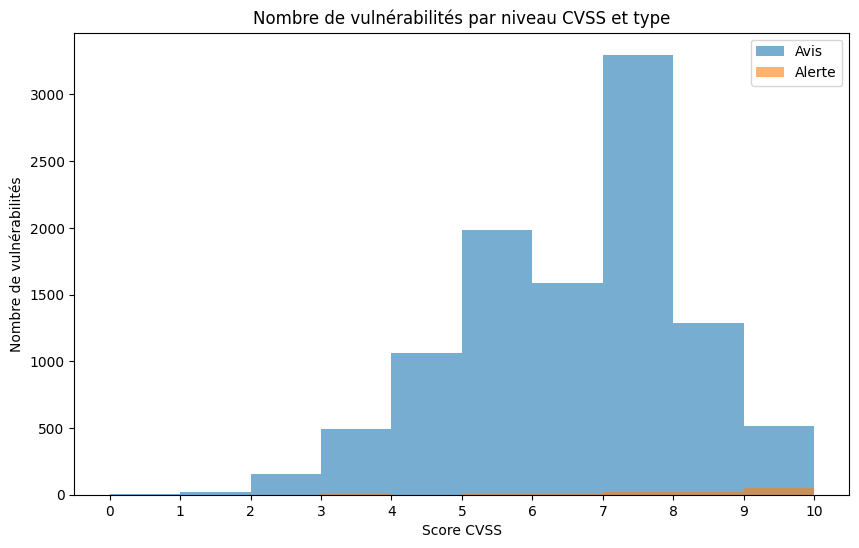

In [120]:
# Histogramme du nombre de vulnérabilités par niveau CVSS et par type (type_encoded)
plt.figure(figsize=(10,6))
bins = range(0, 11)  # CVSS de 0 à 10
for tval, label in zip([0, 1], ['Avis', 'Alerte']):
    subset = df_cleaned[df_cleaned['type_encoded'] == tval]
    plt.hist(subset['cvss'], bins=bins, alpha=0.6, label=label)
plt.title('Nombre de vulnérabilités par niveau CVSS et type')
plt.xlabel('Score CVSS')
plt.ylabel('Nombre de vulnérabilités')
plt.legend()
plt.xticks(bins)
plt.show()

## 2. Diagramme circulaire des types de vulnérabilités (CWE)

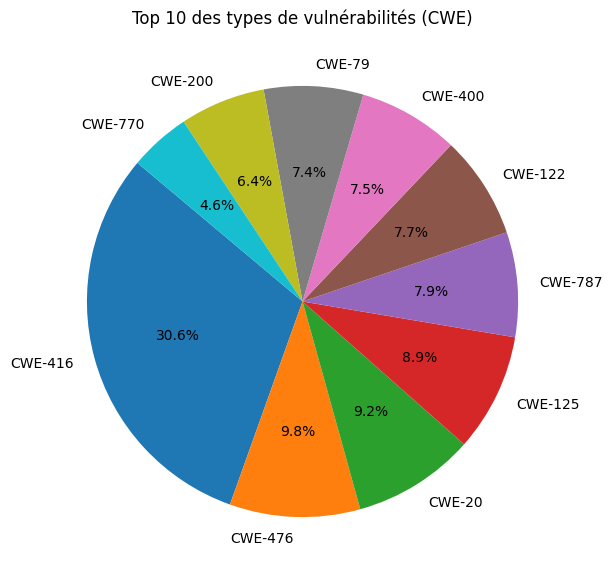

In [108]:
# Utiliser uniquement les lignes où 'cwe' existe, n'est pas NaN, et n'est pas "Non disponible"
df_cwe = df[df['cwe'].notna() & (df['cwe'] != '') & (df['cwe'] != 'Non disponible')]
cwe_counts = df_cwe['cwe'].value_counts().head(10)
plt.figure(figsize=(7,7))
plt.pie(cwe_counts, labels=cwe_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 des types de vulnérabilités (CWE)')
plt.show()

## 3. Courbe des scores EPSS (logarithmique)

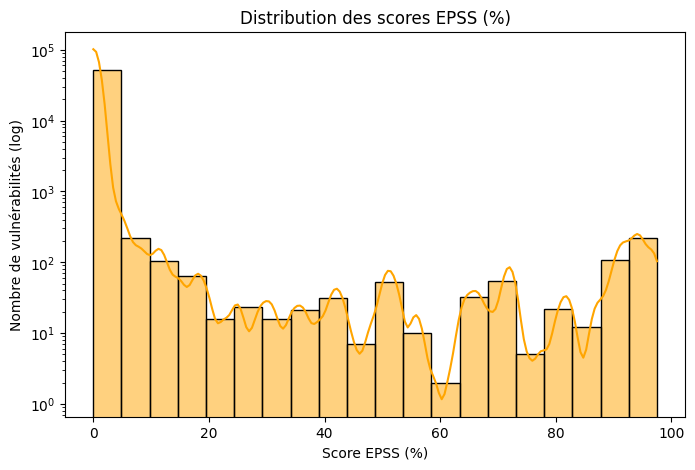

In [109]:
# Afficher la distribution des scores EPSS en pourcentage (0 à 100%) avec une échelle logarithmique sur l'axe Y
epss_percent = df['epss'].dropna().astype(float) * 100
plt.figure(figsize=(8,5))
sns.histplot(epss_percent, bins=20, kde=True, color='orange')
plt.yscale('log')
plt.title('Distribution des scores EPSS (%)')
plt.xlabel('Score EPSS (%)')
plt.ylabel('Nombre de vulnérabilités (log)')
plt.show()

## 4. Classement des produits les plus affectés

In [110]:
# Exclure les valeurs vides ou 'n/a' dans la colonne 'product' et supprimer les NaN restants
mask = df['product'].notna() & (df['product'] != '') & (df['product'].str.lower() != 'n/a')

df_products = df[mask].copy()

df.head()

,id,title,type,publication_date,cve_id,original_link,epss,description,cwe,cwe_desc,vendor,product,affected_versions,cvss,severity
0,CERTFR-2023-AVI-0001,Bulletin de sécurité Apache 9.0.69 du 14 novem...,Avis,None,CVE-2022-45143,https://tomcat.apache.org/security-9.html#Fixe...,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
1,CERTFR-2023-AVI-0002,Bulletin de sécurité Fortinet FG-IR-22-250 du ...,Avis,None,CVE-2022-45857,None,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
2,CERTFR-2023-AVI-0002,Bulletin de sécurité Fortinet FG-IR-22-250 du ...,Avis,None,CVE-2022-35845,None,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
3,CERTFR-2023-AVI-0002,Bulletin de sécurité Fortinet FG-IR-22-250 du ...,Avis,None,CVE-2022-39947,None,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None
4,CERTFR-2023-AVI-0002,Bulletin de sécurité Fortinet FG-IR-22-250 du ...,Avis,None,CVE-2022-41336,None,NaN,None,Non disponible,Non disponible,[],[],[],NaN,None


C:\Users\maxim\AppData\Local\Temp\ipykernel_27884\62893341.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


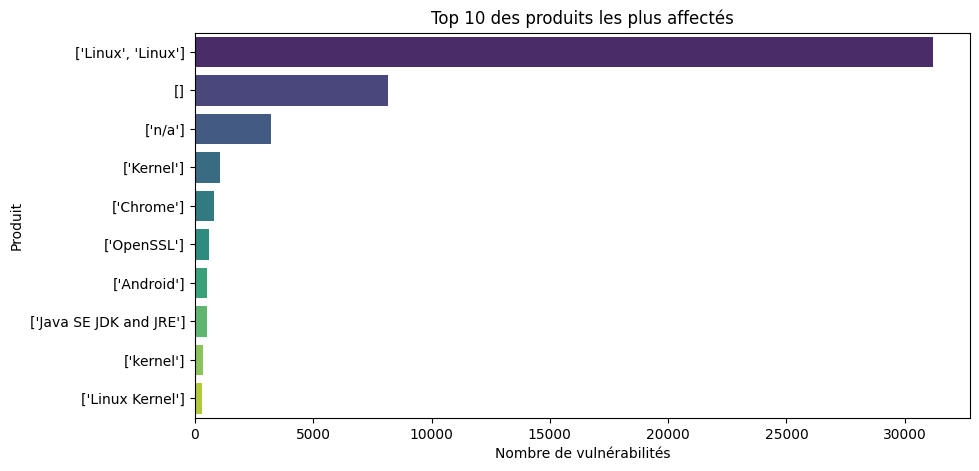

In [111]:
df_products['Produit_str'] = df_products['product'].astype(str)
top_products = df_products['Produit_str'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 des produits les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.ylabel('Produit')
plt.show()



## 5. Nuage de points entre Score CVSS et Score EPSS

Corrélation linéaire CVSS / EPSS : 0.166


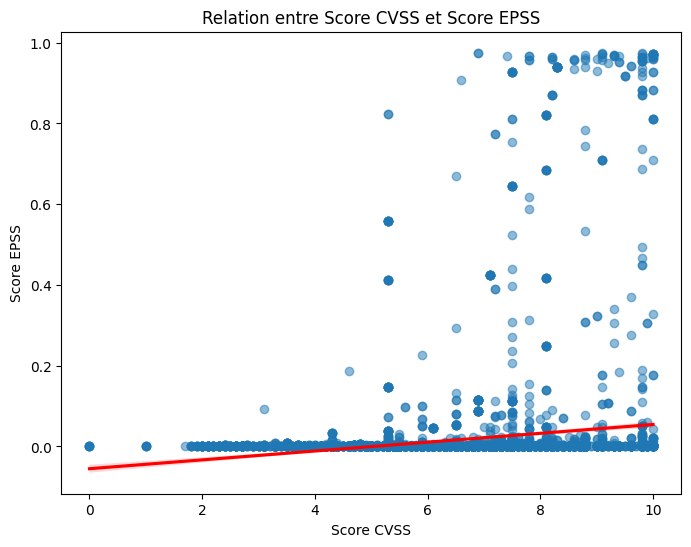

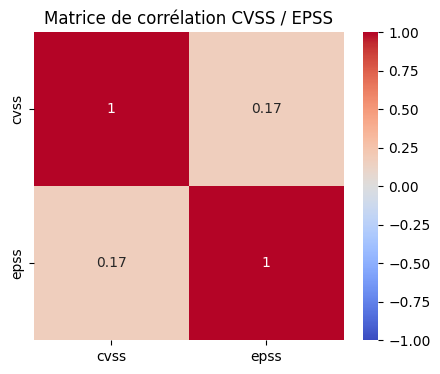

In [112]:
# Analyse de l'impact du score CVSS sur le score EPSS

# Nettoyer les données pour ne garder que les lignes avec CVSS, EPSS et severity valides
df_corr = df[['cvss', 'epss', 'severity']].dropna().copy()
df_corr['cvss'] = df_corr['cvss'].astype(float)
df_corr['epss'] = df_corr['epss'].astype(float)

# 1. Afficher la corrélation linéaire
correlation = df_corr['cvss'].corr(df_corr['epss'])
print(f"Corrélation linéaire CVSS / EPSS : {correlation:.3f}")

# 2. Visualiser la relation par un scatterplot avec régression
plt.figure(figsize=(8,6))
sns.regplot(data=df_corr, x='cvss', y='epss', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relation entre Score CVSS et Score EPSS')
plt.xlabel('Score CVSS')
plt.ylabel('Score EPSS')
plt.show()

# 3. Matrice de corrélation complète entre toutes les variables numériques
plt.figure(figsize=(5,4))
corr_matrix = df_corr[['cvss', 'epss']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de corrélation CVSS / EPSS')
plt.show()

## 6. Courbe cumulative des vulnérabilités en fonction du temps (logarithmique)

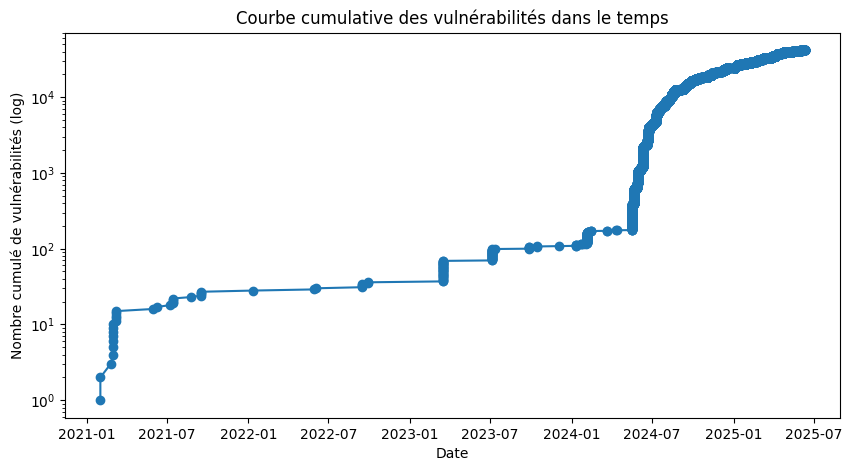

In [113]:
df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')
df_sorted = df.sort_values('publication_date')
df_sorted['cumulative'] = range(1, len(df_sorted)+1)
plt.figure(figsize=(10,5))
plt.plot(df_sorted['publication_date'], df_sorted['cumulative'], marker='o')
plt.yscale('log')
plt.title('Courbe cumulative des vulnérabilités dans le temps')
plt.xlabel('Date')
plt.ylabel('Nombre cumulé de vulnérabilités (log)')
plt.show()

## 7. Boxplot des scores CVSS par éditeur

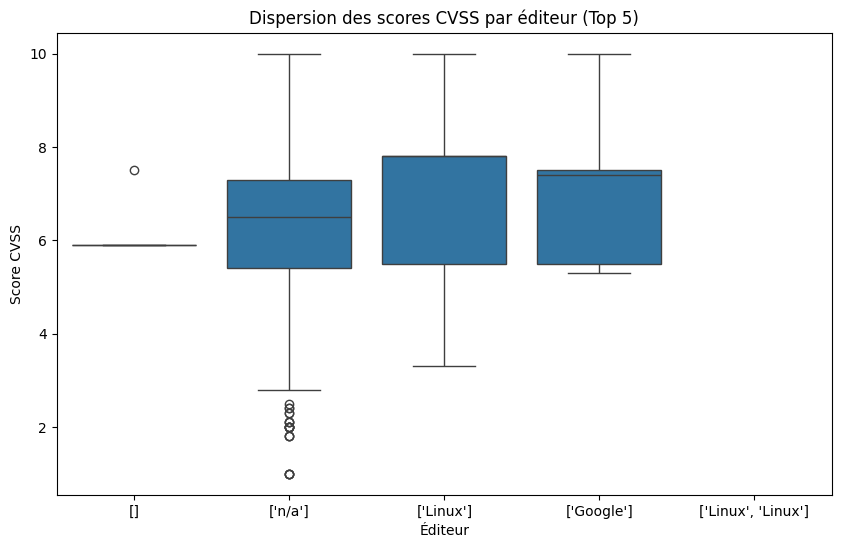

In [114]:
# Nettoyer la colonne 'vendor' pour retirer les valeurs vides ou NaN
df_vendor = df[df['vendor'].notna() & (df['vendor'] != '')]
df_vendor['vendor'] = df_vendor['vendor'].astype(str)
top_editors = df_vendor['vendor'].value_counts().head(5).index
plt.figure(figsize=(10,6))
sns.boxplot(data=df_vendor[df_vendor['vendor'].isin(top_editors)], x='vendor', y='cvss')
plt.title('Dispersion des scores CVSS par éditeur (Top 5)')
plt.xlabel('Éditeur')
plt.ylabel('Score CVSS')
plt.show()

linear regression to predict EPSS :

In [115]:
df_cleaned.head(5)

,id,title,type,publication_date,cve_id,original_link,epss,description,cwe,cwe_desc,vendor,product,affected_versions,cvss,severity,type_encoded
79,CERTFR-2023-AVI-0008,Bulletin de sécurité IBM 6852981 du 05 janvier...,Avis,None,CVE-2022-25647,https://www.ibm.com/support/pages/node/6852981,0.005150000,The package com.google.code.gson:gson before 2...,Non disponible,Deserialization of Untrusted Data,[n/a],[com.google.code.gson:gson],[unspecified],7.7,HIGH,0
87,CERTFR-2023-AVI-0010,Bulletin de sécurité Ubuntu USN-5789-1 du 05 j...,Avis,None,CVE-2022-3567,None,0.000570000,A vulnerability has been found in Linux Kernel...,CWE-362,CWE-362 Race Condition,[Linux],[Kernel],[n/a],4.6,MEDIUM,0
88,CERTFR-2023-AVI-0010,Bulletin de sécurité Ubuntu USN-5789-1 du 05 j...,Avis,None,CVE-2022-3564,None,0.000450000,A vulnerability classified as critical was fou...,CWE-119,CWE-119 Memory Corruption -> CWE-416 Use After...,[Linux],[Kernel],[n/a],5.5,MEDIUM,0
89,CERTFR-2023-AVI-0010,Bulletin de sécurité Ubuntu USN-5789-1 du 05 j...,Avis,None,CVE-2022-3524,None,0.002110000,A vulnerability was found in Linux Kernel. It ...,CWE-404,CWE-404 Denial of Service -> CWE-401 Memory Leak,[Linux],[Kernel],[n/a],4.3,MEDIUM,0
91,CERTFR-2023-AVI-0010,Bulletin de sécurité Ubuntu USN-5789-1 du 05 j...,Avis,None,CVE-2022-3594,None,0.006650000,A vulnerability was found in Linux Kernel. It ...,CWE-404,CWE-404 Denial of Service -> CWE-779 Logging o...,[Linux],[Kernel],[n/a],5.3,MEDIUM,0


Régression pour prédire le score CVSS à partir des features numériques et TF-IDF :
  R2 score (test)     : 0.6469
  RMSE (test)         : 0.9739
  MAE (test)          : 0.6856


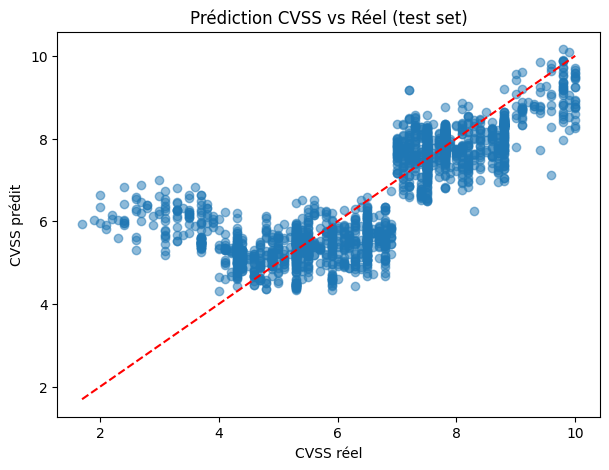

In [126]:
# Régression pour prédire le score CVSS à partir des features numériques et TF-IDF (description et titre)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

# Préparation des features numériques
features = ['epss']
if 'severity' in df_cleaned.columns:
    df_cleaned['severity_encoded'] = df_cleaned['severity'].astype('category').cat.codes
    features.append('severity_encoded')

X_num = df_cleaned[features].fillna(0)

# Préparation des features textuelles (description et titre)
desc = df_cleaned['description'].fillna('')
titre = df_cleaned['title'].fillna('')

tfidf_desc = TfidfVectorizer(max_features=100)
tfidf_titre = TfidfVectorizer(max_features=50)

X_desc = tfidf_desc.fit_transform(desc)
X_titre = tfidf_titre.fit_transform(titre)

# Standardiser les features numériques
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Concaténer toutes les features (numériques + textuelles)
X_all = hstack([csr_matrix(X_num_scaled), X_desc, X_titre])

y = df_cleaned['cvss'].astype(float)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

# Modèle de régression
reg = LinearRegression()
reg.fit(X_train, y_train)

# Prédictions
y_pred = reg.predict(X_test)

# Évaluation
print("Régression pour prédire le score CVSS à partir des features numériques et TF-IDF :")
print(f"  R2 score (test)     : {r2_score(y_test, y_pred):.4f}")
print(f"  RMSE (test)         : {mean_squared_error(y_test, y_pred):.4f}")
print(f"  MAE (test)          : {mean_absolute_error(y_test, y_pred):.4f}")

# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('CVSS réel')
plt.ylabel('CVSS prédit')
plt.title('Prédiction CVSS vs Réel (test set)')
plt.show()

Répartition des vulnérabilités par cluster :
cluster
0    5021
1    4630
2     673
3     178
Name: count, dtype: int64


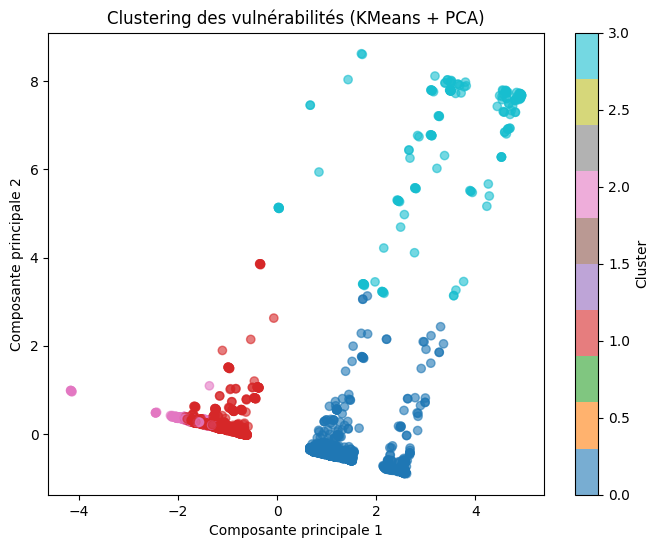

In [129]:
# Clustering des vulnérabilités avec KMeans (features : epss, cvss, severity_encoded, TF-IDF description/titre)

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Préparation des features numériques
features = ['cvss', 'epss']
if 'severity' in df_cleaned.columns:
    df_cleaned['severity_encoded'] = df_cleaned['severity'].astype('category').cat.codes
    features.append('severity_encoded')

X_num = df_cleaned[features].fillna(0)

# TF-IDF sur description et titre
desc = df_cleaned['description'].fillna('')
titre = df_cleaned['title'].fillna('')

tfidf_desc = TfidfVectorizer(max_features=50)
tfidf_titre = TfidfVectorizer(max_features=30)

X_desc = tfidf_desc.fit_transform(desc)
X_titre = tfidf_titre.fit_transform(titre)

# Standardisation des features numériques
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Concaténation des features
from scipy.sparse import hstack, csr_matrix
X_all = hstack([csr_matrix(X_num_scaled), X_desc, X_titre])

# KMeans clustering (nombre de clusters arbitraire, par exemple 4)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_all)

# Ajout du cluster au DataFrame
df_cleaned['cluster'] = clusters

# Affichage de la répartition des clusters
print("Répartition des vulnérabilités par cluster :")
print(df_cleaned['cluster'].value_counts())

# Visualisation 2D avec PCA
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_all.toarray())

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_vis[:,0], X_vis[:,1], c=clusters, cmap='tab10', alpha=0.6)
plt.title('Clustering des vulnérabilités (KMeans + PCA)')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.colorbar(scatter, label='Cluster')
plt.show()